# 1-D Parabolic Equations
Recall that the governing equation (in 1D) is:

$$\frac{\partial u}{\partial t}=\kappa\left(\frac{\partial^2 u}{\partial x^2}\right)$$

To solve the equation we need both boundary condition values at _u(x0,t)_ and _u(x1,t)_ and also initial conditions at _u(x,0)_.

We will need a class to store the 1D grid, set the initial conditions and update the boundary conditions.  Fortunately the grid generation is simpler than  the 2D case.

To set up the initial condtions we will pass a function _f(x)_ to the function, this will be called inside a loop passing the _x_ orfdinate of evergy grid point.  A similar idea will be used for Dirichlet boundary condtions where a function _f(t)_ will be passed as a parameter.  Here is the code for the initial conditions:

    def initial_conditions(self,fun):
        for i in range(self.N_i):
            self.u[0,i] = fun(self.x[i])

Finally we need to know the time step that can be used.  As we saw in the lectures this is characterised by the CFL condition
$$\Delta t \le \nu \frac{\Delta x^2}{2\kappa}$$

The choice of ν depends on the solver being used so we will pass it as a parameter:

    def set_Delta_t(self,Coutrant_number):
        self.Delta_t = Coutrant_number * self.Delta_x()**2/(2*self.kappa) 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

def one(t):
    '''simple function of x and t which allways returns 1.0'''
    return 1.0

class Grid:
    '''Class defining the grid for a 1D parabolic solver.  Solving
    
    $$\frac{\partial u}{\partial t}=\kappa\left(\frac{\partial^2 u}{\partial x^2}\right)$$

    The grid object contains the number of grid points (Ni), left
    and right ordinates (x0 and x1), flags for wether the boundaries
    are Dirichlet or Neumann boundary conditions and functions for
    plotting the solution both at a particular time level and in the
    form of an x-t plot.  The grid also contains the solution vector (u)
    which is stored as an array with differnt time levels, together with
    the number of time steps N_t and the (uniform) time step Delta_t.
    
    Written by Prof David Ingram, School of Engineering
    (c) 2021 The University of Edinburgh
    Licensed under CC-BY-NC.
    '''
    
    DIRICHLET_BC = 0
    NEUMANN_BC = 1

    BC_NAME = ['left', 'right']
    
    def __init__(self,ni):
        # set up information about the grid
        self.x0 = 0.0 #  left
        self.x1 = 1.0 #  right
        self.N_i = ni # grid points in i direction
        self.N_t = 0 # how many time steps have we performed
        self.Delta_t = 0.0 # no dt value yet
        self.kappa = 1.0 # Thermal Diffusivity

        # initialse x,y and u arrays
        self.u = np.zeros((1,ni))
        self.x = np.zeros(ni)
        self.t = np.zeros(1)

        # boundary conditions (left and right )
        self.BC = [ self.DIRICHLET_BC, self.DIRICHLET_BC ]
        self.BC_fun = [ one, one ]

    def set_x0(self,x0):
        self.x0 = x0
    
    def set_x1(self,x1):
        self.x1 = x1
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        x0 to the x1.  We are going to do this using linspace from
        numpy to create a list of x ordinates.'''
        self.x = np.linspace(self.x0, self.x1, self.N_i)
        if not Quiet:
            print(self)

    def initial_conditions(self,fun):
        '''set the initial conditions by calling the specified function
        fun(x) at every ordinate'''
        for i in range(self.N_i):
            self.u[0,i] = fun(self.x[i])

    def Delta_x(self):
        # calculate delta x
        return self.x[1]-self.x[0]
    
    def set_Neumann_bc(self,side):
        try:
             self.BC[self.BC_NAME.index(side)] = self.NEUMANN_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))
     
    def set_Dirichlet_bc(self,side,fun):
        '''set the Dirichlet boundary condition.  As well as the side
        this must be passed a function fun(t) which returns the value
        associated with the Dirichlet boundary at the time t.'''
        try:
            self.BC[self.BC_NAME.index(side)] = self.DIRICHLET_BC
        except:
            print('error {} must be one of {}'.format(side,self.BC_NAME))
        self.BC_fun[self.BC_NAME.index(side)] = fun

    def set_Delta_t(self,Coutrant_number):
        # set the time step using the Courant-Friedirchs-Lewey condition
        self.Delta_t = Coutrant_number * self.Delta_x()**2/(2*self.kappa) 
            
    def apply_BC(self,t):
        '''Apply the left and right boundary conditions to the values in
        the latest value of u at the current time level'''
        # left boundary
        if self.BC[0]==self.NEUMANN_BC:
            self.u[-1,0] = self.u[-1,2]
        else:
            self.u[-1,0] = self.BC_fun[0](t)
        
        # right
        if self.BC[1]==self.NEUMANN_BC:
            self.u[-1,-1] = self.u[-1,-3]
        else:
            self.u[-1,-1] = self.BC_fun[1](t)
    
    def integrate(self,t_stop,solver):
        '''call the integrator defined by solver to integrate
        the solution from t=0 to t=t_stop.'''
        
        time = 0.0
        o_time = t_stop/10
        print('Integratung to {:.3g} seconds Δt={:.3g} :'.format(t_stop,self.Delta_t),end='')
        
        # save the initial conditions as the first saved result
        self.u = np.vstack([self.u, self.u])
        self.t = np.vstack([self.t, 0.0])

        # time loop
        while True:
            # short time step at the end
            dt = min(self.Delta_t,t_stop-time)
            
            # update the boundary conditions and call the solver
            self.apply_BC(time)
            
            # update the time and save the time and results
            time += dt
            self.u[-1] = solver(self)
            self.t[-1] = time

            # progress monitor
            if (time >= o_time) & (time<t_stop):
                print('#',end='')
                o_time += t_stop/10
                self.t = np.vstack([self.t, time])
                self.u = np.vstack([self.u, self.u[-1]])
                self.N_t += 1
 
            # are we done
            if time >= t_stop:
                print('. ')
                break
        
    def plot(self,title):
        '''plot the solution at the current time level.  If there are
        more than 30 points in the x-direction then a line is used.'''
        if self.N_i<30:
            plt.plot(self.x,self.u[self.N_t],'ob')
        else:
            plt.plot(self.x,self.u[self.N_t],'-b')
        plt.title(title+', t={:.2f}'.format(self.N_t*self.Delta_t))
        plt.show()
        
    def report_BC(self):
        '''compile a string listing the boundary conditions on each side.
        We build up a string of two {side name}: {BC type} pairs and
        return it'''
        
        # initialise the string
        string = ''
        
        # loop over the sides
        for side in range(2):
            # add the side name
            string = string + self.BC_NAME[side]
            # and the bounday condition type
            if self.BC[side] == self.DIRICHLET_BC:
                string = string + ': Dirichlet, '
            elif self.BC[side] == self.NEUMANN_BC:
                string = string + ': Neumann, '
        return string[:-2] +'.' # lose the last comma and space.
    
    def __str__(self):
        # describe the object when asked to print it
        describe = 'Parabolic problem, 𝜅={:.3g}\n'.format(self.kappa)
        describe += 'Uniform {} node grid from {} to {}.\n'.format(self.N_i, self.x0, self.x1)
        describe += 'Boundaries conditions are - ' + self.report_BC()
        if self.N_t==0:
            describe += '\nInitial conditions at t=0.0, Δt={:.3g} seconds'.format(self.Delta_t)
        else:
            describe += '\n{} time steps from t=0.0 to t={:.3g}, Δt={:.3g} seconds'.format(self.N_t+1,self.N_t*self.Delta_t,self.Delta_t)
        return describe

### A test problem
We have a 1m long domain from _x_=0.0 to _x_=1.0 with 𝜅=1.0.  The initial conditions are
$$u(x,0)=\sin \frac{3\pi x}{2}$$
and we have a Dirichlet boundary condition with _u_(0,_t_)=0.0 at _x_=0.0 and a Neumann boundary condition _u'_(1,_t_)=0.0 at _x_=1.0.

This problem has an analytical solution 
$$u(x,t)=\exp\left(-\frac{9\kappa\pi^2 t}{4}\right)\sin\frac{3\pi x}{2}.$$

Let's set it up

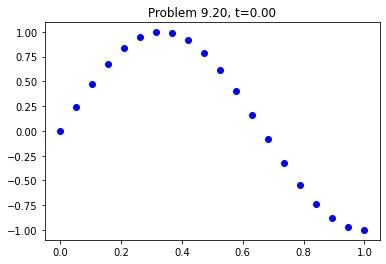

Parabolic problem, 𝜅=1
Uniform 20 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=0.00132 seconds


In [2]:
def u_bc(x):
    return 0.0

def u_init(x):
    return np.sin(3*np.pi*x/2)

test = Grid(20)
test.generate()
test.set_Delta_t(0.95)
test.set_Neumann_bc('right')
test.set_Dirichlet_bc('left',u_bc)
test.initial_conditions(u_init)
test.plot('Problem 9.20')
print(test)


## The FTCS Scheme
Replacing the time derivities with the first order, forward, finite difference approximation and the second derivative with the 2nd order central finite difference apporximation and introducing the index _n_ to represent the time level we obtain:
$$\frac{u_{i}^{n+1}-u_{i}^n}{\Delta t}=\kappa\frac{u^n_{i-1}-2u^n_i+u^n_{i+1}}{\Delta x^2}.$$
This can be re-arranged to obtain the explicit time-marching method:
$$u_i^{n+1}=u^n_i+\frac{\kappa\Delta t}{\Delta x^2}\left(u^n_{i-1}-2u^n_i+u^n_{i+1}\right).$$
This is the well known Forward-Time, Centred-Space (FTCS) scheme.  If is formally 1<sup>st</sup> order in time and 2<sup>nd</sup> order in space.





Integratung to 0.1 seconds Δt=0.00132 :#########. 


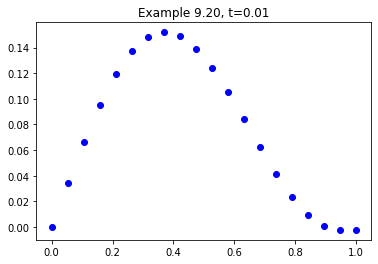

Parabolic problem, 𝜅=1
Uniform 20 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
10 time steps from t=0.0 to t=0.0118, Δt=0.00132 seconds


In [3]:
def FTCS(grid):
    '''perform one time step using the FTCS scheme on the parabolic 
    problem defined by grid. We are using whole array opperations
    for speed.'''
    Rx = grid.kappa*grid.Delta_t/grid.Delta_x()**2
    u = grid.u[-1].copy()
    u[1:-1]=u[1:-1]+Rx*(u[0:-2]-2*u[1:-1]+u[2:])
    return u

test.integrate(0.1, FTCS)
test.plot('Example 9.20')
print(test)


Integratung to 0.1 seconds Δt=0.00132 :#########. 


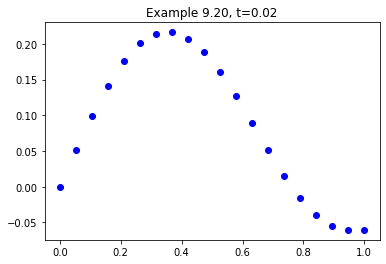

Parabolic problem, 𝜅=1
Uniform 20 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
19 time steps from t=0.0 to t=0.0237, Δt=0.00132 seconds


In [4]:
# do annother 0.1 seconds
test.integrate(0.1, FTCS)
test.plot('Example 9.20')
print(test)

Integratung to 0.1 seconds Δt=1.19e-05 :#########. 


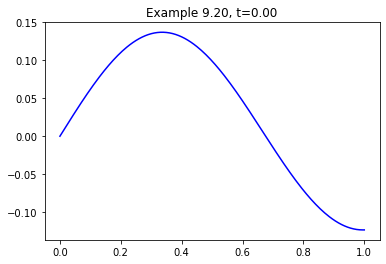

Parabolic problem, 𝜅=1
Uniform 201 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
10 time steps from t=0.0 to t=0.000107, Δt=1.19e-05 seconds


In [5]:
# more grid points
test1 = Grid(201)
test1.generate()
test1.set_Delta_t(0.95)
test1.set_Neumann_bc('right')
test1.set_Dirichlet_bc('left',u_bc)
test1.initial_conditions(u_init)
test1.integrate(0.1, FTCS)
test1.plot('Example 9.20')
print(test1)


### X-t plot
Because we have stored every time step, we can plot a contour plot of the solution with time on one axis and space on the other.  To do this we must:
1. create a <code>meshgrid</code> using _x_ and _t_
2. plot the contour plot
3. add a colour bar
4. add titles and captions


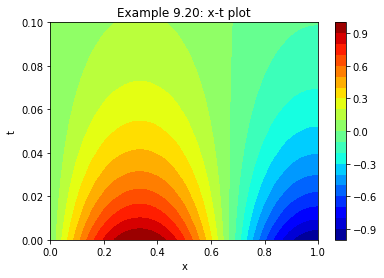

In [6]:
X,T = np.meshgrid(test1.x,test1.t)
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('jet')
cf = ax1.contourf(X,T,test1.u,cmap=cmap, levels = 21)
fig.colorbar(cf, ax=ax1)
ax1.set_title('Example 9.20: x-t plot')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
plt.show()


### Analysis

The _x_-_t_ plot shows the expected behaviour with the amplitude of the oscilation decaying as time increases.

We can compare the solution with the analytical one as well


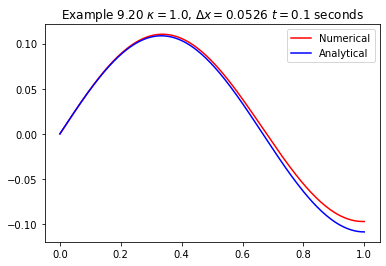

In [7]:
plt.plot(test1.x,test1.u[-1],'r-',label='Numerical')
u_exact = np.exp(-9*test1.kappa*np.pi**2*test1.t[-1]/4)*np.sin(1.5*np.pi*test1.x)
plt.plot(test1.x,u_exact,'b-',label='Analytical')
plt.title('Example 9.20 $\kappa=1.0$, $\Delta x={:.3g}$ $t=0.1$ seconds'.format(test.Delta_x()))
plt.legend()
plt.show()

## Mesh refinement study
In this case we are going to use the range of _u(x)_ as the integrating quantity.

$$\text{Range}(u)=\max_i u - \min_i u$$

We will run the solution to _t_=0.1 seconds and use 𝜅=1.0  As with the Laplace Solvers I'm going to use a sequence of grids with

$$N_i = 20\times2^n + 1 \ n=1 \ldots 8.$$

The finest grid will have 5121 grid points and the coarsest 81.  The finest grid will take about 5 mins to run.  We are also going to plot the solution on every grid (together with the analytical solution).  

Parabolic problem, 𝜅=1
Uniform 5121 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=1.81e-08 seconds
Integratung to 0.1 seconds Δt=1.81e-08 :#########. 
The solver took  0:03:15.949241
Range(u) is  0.2166936165544986 



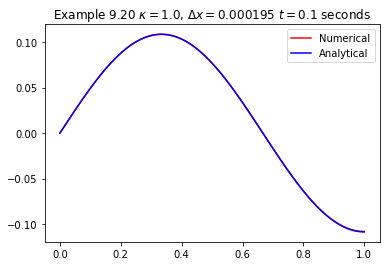

Parabolic problem, 𝜅=1
Uniform 2561 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=7.25e-08 seconds
Integratung to 0.1 seconds Δt=7.25e-08 :#########. 
The solver took  0:00:29.109511
Range(u) is  0.21631240457900092 



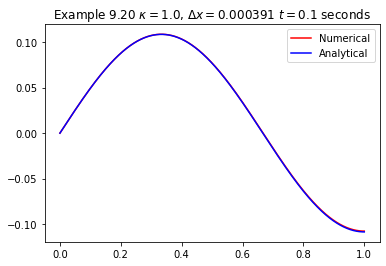

Parabolic problem, 𝜅=1
Uniform 1281 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=2.9e-07 seconds
Integratung to 0.1 seconds Δt=2.9e-07 :#########. 
The solver took  0:00:05.173283
Range(u) is  0.21554936039230999 



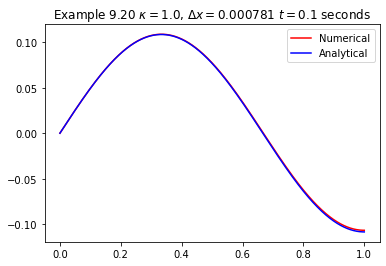

Parabolic problem, 𝜅=1
Uniform 641 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=1.16e-06 seconds
Integratung to 0.1 seconds Δt=1.16e-06 :#########. 
The solver took  0:00:01.221464
Range(u) is  0.2140228288950144 



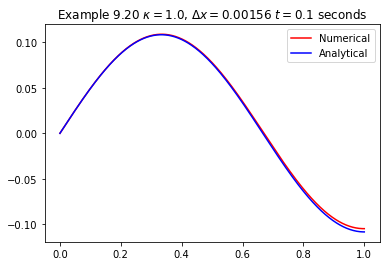

Parabolic problem, 𝜅=1
Uniform 321 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=4.64e-06 seconds
Integratung to 0.1 seconds Δt=4.64e-06 :#########. 
The solver took  0:00:00.379778
Range(u) is  0.21096840720015725 



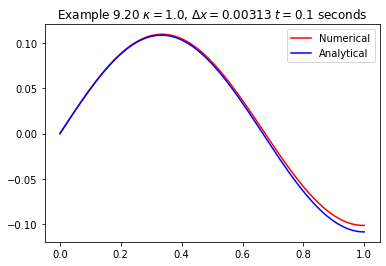

Parabolic problem, 𝜅=1
Uniform 161 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=1.86e-05 seconds
Integratung to 0.1 seconds Δt=1.86e-05 :#########. 
The solver took  0:00:00.112687
Range(u) is  0.20481105553606624 



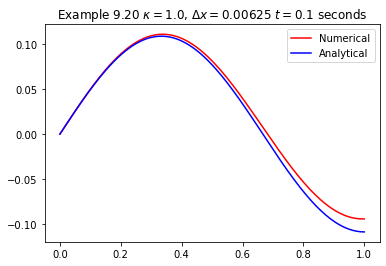

Parabolic problem, 𝜅=1
Uniform 81 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=7.42e-05 seconds
Integratung to 0.1 seconds Δt=7.42e-05 :#########. 
The solver took  0:00:00.048300
Range(u) is  0.19236136289501543 



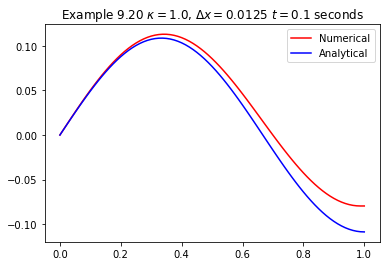

In [8]:
import datetime # just seconds may not be enough

# we need some lists u and dx values
U_val = []
dx_val = []
run_time = []
n_pts =[]
for grid_index in range(8,1,-1):
    ni = 20 * 2**grid_index + 1
    n_pts.append(ni)
    
    # set up the problem
    test = Grid(ni)
    test.generate()
    test.set_Delta_t(0.95)
    test.set_Neumann_bc('right')
    test.set_Dirichlet_bc('left',u_bc)
    test.initial_conditions(u_init)
    print(test)
    
    # run the solver
    start = time.process_time()
    test.integrate(0.1, FTCS)
    stop = time.process_time()
    elapsed = datetime.timedelta(seconds=stop-start)
    print("The solver took ",elapsed)

    # save dx and the range into the list for evalutation
    dx_val.append(test.Delta_x())
    U_val.append(np.max(test.u[-1])-np.min(test.u[-1]))
    run_time.append(stop-start)
        
    print('Range(u) is ',U_val[-1],'\n')    

    # plot a graph of the solution and the analytical solution on the same grid.
    plt.plot(test.x,test.u[-1],'r-',label='Numerical')
    u_exact = np.exp(-9*test.kappa*np.pi**2*test.t[-1]/4)*np.sin(1.5*np.pi*test.x)
    plt.plot(test.x,u_exact,'b-',label='Analytical')
    plt.title('Example 9.20 $\kappa=1.0$, $\Delta x={:.3g}$ $t=0.1$ seconds'.format(test.Delta_x()))
    plt.legend()
    plt.show()


Refinement Analysis on 7 grids.

Grid Delta x ratio  range(u)
----------------------------
   1 0.0001953     2  0.216694
   2 0.0003906     2  0.216312
   3 0.0007813     2  0.215549
   4 0.001563     2  0.214023
   5 0.003125     2  0.210968
   6 0.00625     2  0.204811
   7  0.0125   ---  0.192361
---------------------------- 

order of convergence, p =   1.00

Grids       GCI
---------------
 1  2  0.002195
 2  3  0.004402
 3  4  0.008838
 4  5   0.01781
 5  6   0.03642
 6  7   0.07586
---------------

 Grid Step  GCI Ratio Converged
-------------------------------
 1 2  2 3      0.9982 True
 2 3  3 4       0.997 True
 3 4  4 5      0.9933 True
 4 5  5 6      0.9788 False
 5 6  6 7      0.9611 False
-------------------------------



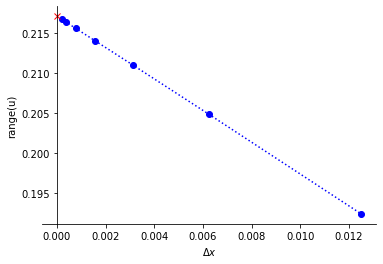

In [9]:
# now run the mesh refinement analysis
from refinement_analysis import refinement_analysis
# lets to the refinement analysis
analysis = refinement_analysis(dx_val,U_val)
analysis.report('range(u)')
analysis.plot(True,'range(u)')

### Analysis
The method has an apparent accuracy of first order.  We expect this since it's 2nd order in space and 1st order in time.  We've taken a lot of time steps so accuracy is at most 1st order.  On the finest grids (_Ni_>320) the solution is grid converged (and it's prety close on the other grids).  So what about the execution time

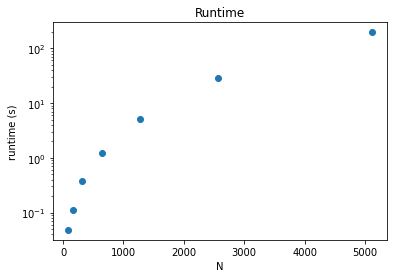

In [10]:
# plot the runtime
plt.plot(n_pts,run_time,'o')
plt.title('Runtime')
plt.xlabel('N')
plt.yscale('log',base=10) 
plt.ylabel('runtime (s)')
plt.show()